In [1]:
!source ~/.zshrc

In [2]:
import os
from sodapy import Socrata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rtree
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely import wkt
from zipfile import ZipFile
import glob
from datetime import datetime, date


# Establish SodaPy connection
# Establish env variables
username = os.getenv('soc_user')
password = os.getenv('soc_pass')
token = os.getenv('soc_app_token')

# Authenticate client (needed for non-public datasets):
client = Socrata("data.cityofchicago.org", 
                 token, 
                 username=username, 
                 password=password,
                timeout=25)


In [3]:
# Read in neighborhoods geodataframe
chicago = gpd.read_file("data/Boundaries - Community Areas (current)", crs = {'init': 'epsg:4326'})

# Pull Divvy station through socrata API
station_data = client.get('bk89-9dk7')

# Pull Train Data
el_stops = client.get('8pix-ypme')


ERROR:fiona._env:data/Boundaries - Community Areas (current): No such file or directory


DriverError: data/Boundaries - Community Areas (current): No such file or directory

In [4]:
# Create Divvy Station GeoDataFrame
el_stop_df = pd.DataFrame(el_stops)
el_stop_df['latitude'] = el_stop_df['location'].apply(lambda x: float(x['latitude']))
el_stop_df['longitude'] = el_stop_df['location'].apply(lambda x: float(x['longitude']))

el_stops_gpd = gpd.GeoDataFrame(el_stop_df, geometry = gpd.points_from_xy(el_stop_df['longitude'], el_stop_df['latitude']))

NameError: name 'el_stops' is not defined

In [7]:
# Create Pandas DF to fix long & lat
divvy_data = pd.DataFrame(station_data)

divvy_data['longitude'] = divvy_data['longitude'].apply(lambda x: float(x))
divvy_data['latitude'] = divvy_data['latitude'].apply(lambda x: float(x))

In [8]:
# Create Divvy Station data GeoDataFrame
all_divvy_stations = gpd.GeoDataFrame(divvy_data, 
                                      geometry = gpd.points_from_xy(divvy_data['longitude'], divvy_data['latitude']))

# Rename columns
all_divvy_stations.rename(columns={':@computed_region_awaf_s7ux':'Historical Wards 2003-2015',
                              ':@computed_region_6mkv_f3dw':'Zip Codes',
                              ':@computed_region_vrxf_vc4k':'Community Areas',
                              ':@computed_region_bdys_3d7i':'Census Tracts',
                              ':@computed_region_43wa_7qmu':'Wards'},
                     inplace=True)

all_divvy_stations = all_divvy_stations.drop(['Zip Codes', 'location'], axis=1)

#Align CRS types
chicago.crs={'init':'epsg:4326'}
all_divvy_stations.crs = {'init':'epsg:4326'}

#Print Info
all_divvy_stations.info()
print("\n\n")
chicago.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 595 entries, 0 to 594
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   station_name                595 non-null    object  
 1   Wards                       581 non-null    object  
 2   total_docks                 595 non-null    object  
 3   latitude                    595 non-null    float64 
 4   Historical Wards 2003-2015  581 non-null    object  
 5   longitude                   595 non-null    float64 
 6   Census Tracts               581 non-null    object  
 7   status                      595 non-null    object  
 8   Community Areas             581 non-null    object  
 9   docks_in_service            595 non-null    object  
 10  id                          595 non-null    object  
 11  geometry                    595 non-null    geometry
dtypes: float64(2), geometry(1), object(9)
memory usage: 55.9+ KB



<class

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [19]:
#Fix Data Types
divvy_stations = all_divvy_stations[all_divvy_stations['Wards'].isna()==False]
divvy_stations = divvy_stations.drop(['Census Tracts', 'Historical Wards 2003-2015'], axis=1)
divvy_stations['total_docks'] = divvy_stations['total_docks'].apply(lambda x: int(x))
divvy_stations['docks_in_service'] = divvy_stations['docks_in_service'].apply(lambda x: int(x))

#Align CRS types
chicago.crs={'init':'epsg:4326'}

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [20]:
# Define Function to Assign Groups

def assign_sides(ward):
    if ward in far_north_side:
        return "far north side"
    elif ward in northwest_side:
        return "northwest side"
    elif ward in north_side:
        return "north side"
    elif ward in west_side:
        return "west side"
    elif ward in central:
        return "loop"
    elif ward in south_side:
        return "south side"
    elif ward in southwest_side:
        return "southwest side"
    elif ward in far_southwest_side:
        return "far southwest side"
    elif ward in far_south_side:
        return "far south side"
    else:
        return "None"

In [21]:
def find_polygon(coordinate):
    dex =  chicago[chicago['geometry'].contains(coordinate)].index.values[0]
    return chicago['area_num_1'][dex]
    

In [22]:
# Define Chicago Side Groups
far_north_side = ['76', '9', '10', '11', '12', '13', '14', '4', '2', '3', '77', '1']
northwest_side = ['17', '18', '19', '20', '15', '16']
north_side = ['22', '21', '5', '6', '7']
west_side = ['25', '26', '27', '23', '24', '28', '29', '31', '30']
central = ['33', '32', '8']
south_side = ['60', '37', '34', '35', '36', '40', '41', '42', '69', '43', '38', '39']
southwest_side = ['56', '64', '65', '66', '67', '68', '62', '63', '61', '57', '58', '59']
far_southwest_side = ['74', '75', '72', '73', '71', '70']
far_south_side = ['55', '54', '51', '49', '53', '50', '44', '47', '45', '46', '48', '46', '52']


# All Wards List
#all_wards = far_north_side + northwest_side + north_side + west_side + central + south_side + far_southwest_side + southwest_side + far_south_side


In [27]:
#Fix Community Area Data
divvy_stations['fix_area'] = divvy_stations.geometry.apply(lambda x: find_polygon(x))
#el_stops_gpd['community num'] = el_stops_gpd.geometry.apply(lambda x: find_polygon(x))

# Assign Groups
chicago['side'] = chicago['area_num_1'].apply(lambda x: assign_sides(x))
divvy_stations['side'] = divvy_stations['fix_area'].apply(lambda x: assign_sides(x))
#el_stops_gpd['side'] = el_stops_gpd['community num'].apply(lambda x: assign_sidex(x))

# Fix columns
divvy_stations.rename(columns={
    'fix_area':'community num'},
    inplace=True)

#Write divvy_stations to csv
divvy_stations.to_csv('data/divvy_stations.csv', index=False)



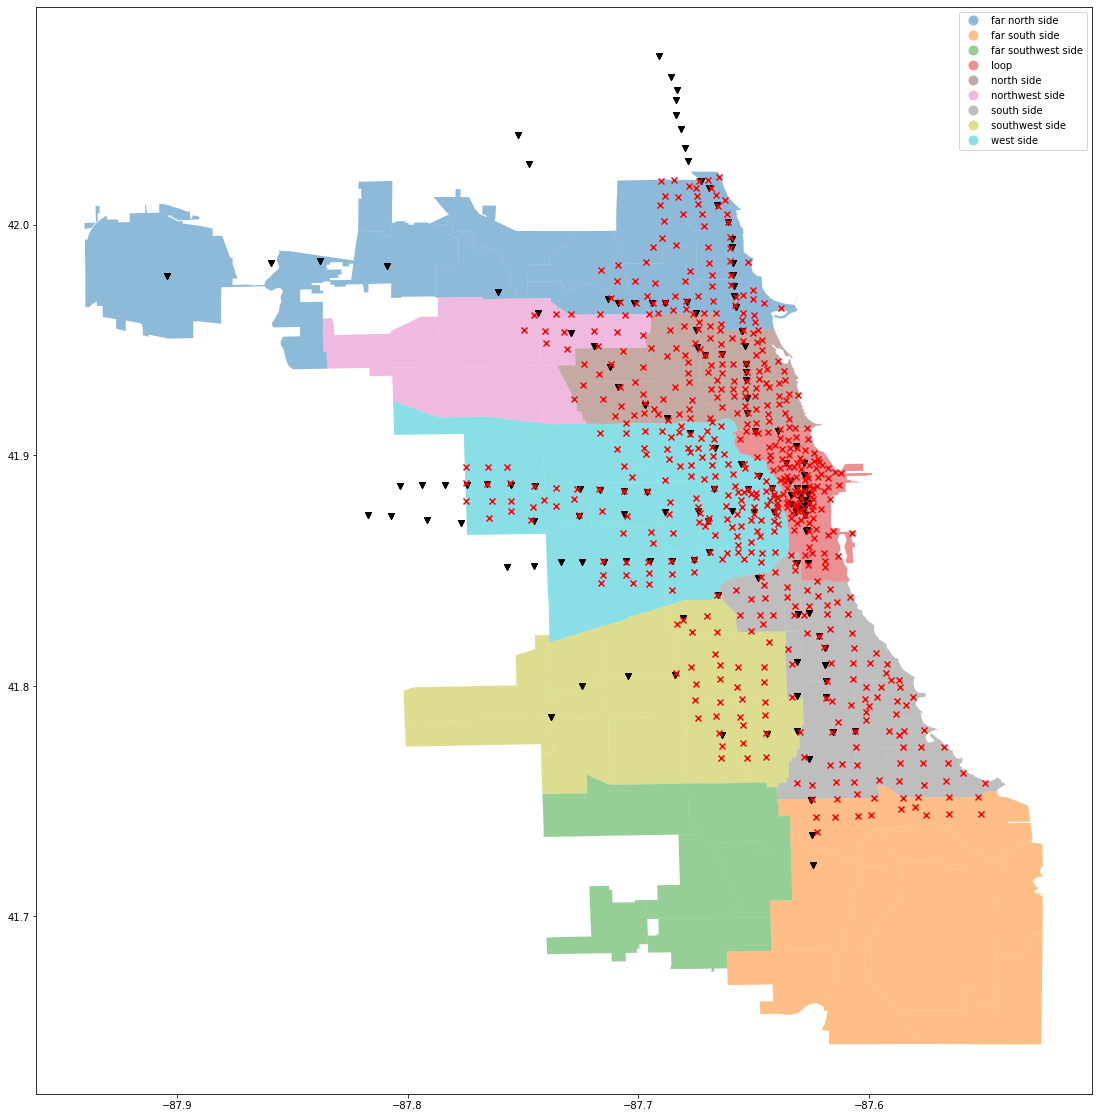

In [36]:
base1 = chicago.plot(figsize=(30,20), alpha=0.5, column='side', legend = True)

base2 = el_stops_gpd.plot(ax=base1, figsize=(30,20), marker ='v', color='black')

final_map = divvy_stations.plot(ax=base2, figsize=(30,20), marker='x', color='red')


In [ ]:
divvy_stations.info()

In [ ]:
# High Level Analysis on Divvy stations by general area of Chicago
station_agg = divvy_stations.groupby(['side']).agg({'id':'count', 
                                                'total_docks':'sum',
                                                'docks_in_service':'sum'})
station_agg.sort_values('id', ascending=False)